In [101]:
import pandas as pd
import numpy as np
import os
import random
import sys
import json
import matplotlib.pyplot as plt

from glob import glob
from itertools import product

from tqdm.auto import tqdm

from PIL import Image

import ipywidgets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

# Configuration

In [2]:
class Config:
    seed = 223 # it's my birthday
    gpu = 0 
    
    val_ratio = 0.3
    batch_size = 24
    epochs = 5
    
    lr = 0.001
    
config = Config()

In [3]:
device = f'cuda:{config.gpu}' if torch.cuda.is_available() else 'cpu'

In [4]:
def torch_seed(random_seed: int = 223):
    """
    set deterministic seed

    Argument
    --------
    - random_seed : random seed number, default 223 is my birth day. haha

    """
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

# Load Data

In [5]:
train_info = pd.read_csv('../data/FIW/train-pairs.csv')

In [6]:
img_path = []

for i in tqdm(range(len(train_info))):
    # image path
    p1_path = glob(f'../data/FIW/train-faces/{train_info.p1.tolist()[i]}/*.jpg')
    p2_path = glob(f'../data/FIW/train-faces/{train_info.p2.tolist()[i]}/*.jpg')
    img_path.extend(list(product(p1_path, p2_path)))

In [7]:
img_path = pd.DataFrame(img_path, columns=['p1','p2'])

## Split Train and Validation Set

In [8]:
# random shuffle
torch_seed(config.seed)
val_path = img_path.sample(frac=config.val_ratio)
train_path = img_path.drop(val_path.index, axis=0)

## Build Dataset and DataLoader

In [9]:
class KinshipDataset(torch.utils.data.Dataset):
    def __init__(self, img_path, transform):
        self.p1 = img_path['p1'].tolist()
        self.p2 = img_path['p2'].tolist()
        self.transform = transform
        
    def __len__(self):
        return len(self.p1)
    
    def __getitem__(self, idx):
        
        # anchor, positive, and negative image path
        anchor_path = self.p1[idx]
        anchor_fam = anchor_path.split('/')[-2]
        
        positive_path = self.p2[idx]
    
        negative_fam = anchor_fam
        while anchor_fam == negative_fam:
            negative_path = np.random.choice(self.p2, size=1)[0]
            negative_fam = negative_path.split('/')[-2]
            
        # load images and convert RGB to grayscale
        anchor = Image.open(anchor_path).convert("L")
        positive = Image.open(positive_path).convert("L")
        negative = Image.open(negative_path).convert("L")
            
        # transform
        anchor = self.transform(anchor)
        positive = self.transform(positive)
        negative = self.transform(negative)
        
        return anchor, positive, negative

In [10]:
transform = transforms.Compose([
    transforms.Resize((124,124)),
    transforms.ToTensor(),
])

In [11]:
trainset = KinshipDataset(img_path=train_path, transform=transform)
valset = KinshipDataset(img_path=val_path, transform=transform)

In [12]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=config.batch_size,
                                          shuffle=True,
                                          num_workers=8)
valloader = torch.utils.data.DataLoader(valset,
                                        batch_size=config.batch_size,
                                        shuffle=False,
                                        num_workers=8)

# ResNet

- ResNet code source : https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
- Paper : Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, Deep Residual Learning for Image Recognition. arXiv:1512.03385

In [13]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False) # grayscale
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.mean(axis=1) # GAP
        out = out.view(out.size(0), -1)
        return out
    
def ResNet18Kinship():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [14]:
model = ResNet18Kinship().to(device)

# Train

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
criterion = nn.TripletMarginLoss()

In [16]:
def train(model, trainloader, optimizer, criterion, device):
    total_loss = 0
    for batch_idx, (anchors, positives, negatives) in enumerate(trainloader):
        # inputs and targets
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
        
        # model output
        anchors_output = model(anchors.to(device))
        positives_output = model(positives.to(device))
        negatives_output = model(negatives.to(device))
        
        # loss and update
        optimizer.zero_grad()
        loss = criterion(anchors_output, positives_output, negatives_output)
        loss.backward()
        optimizer.step()
        
        # history
        total_loss += loss.item()

        if batch_idx == len(trainloader)-1:
            print()
        else:
            sys.stdout.write(f'\rStep [{batch_idx+1}/{len(trainloader)}] Loss: {total_loss/(batch_idx+1):.4f}')
        
    return total_loss / len(trainloader)

def test(model, testloader, criterion, device):
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (anchors, positives, negatives) in enumerate(testloader):
            # inputs and targets
            anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
            

            # model output
            anchors_output = model(anchors.to(device))
            positives_output = model(positives.to(device))
            negatives_output = model(negatives.to(device))

            # loss
            loss = criterion(anchors_output, positives_output, negatives_output)

            # history
            total_loss += loss.item()

            if batch_idx == len(testloader)-1:
                print()
            else:
                sys.stdout.write(f'\rStep [{batch_idx+1}/{len(testloader)}] Loss: {total_loss/(batch_idx+1):.4f}')
        
    return total_loss / len(testloader)

class CheckPoint:
    def __init__(self, savedir):
        self.best_loss = 9999
        if not os.path.isdir(savedir):
            os.makedirs(savedir)
    
    def step(self, model, loss):        
        if loss < self.best_loss:    
            # print
            print(f'Model Save : Best Loss {self.best_loss:.4f} -> {loss:.4f}')
            
            state = {
                'net': model.state_dict(),
                'loss': loss,
                'epoch': 1,
            }

            torch.save(state, f'../checkpoint/FIW_{loss:.4f}.pth')
        
            self.best_loss = loss            

In [17]:
torch_seed(config.seed)

checkpoint = CheckPoint(savedir='../checkpoint')

train_loss_list = []
val_loss_list = []
for epoch in range(config.epochs):
    print(f'\nEpochs [{epoch+1}/{config.epochs}]')
    train_loss = train(model, trainloader, optimizer, criterion, device)
    val_loss = test(model, valloader, optimizer, criterion, device)
    
    # history
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    # checkpoint
    checkpoint.step(model, val_loss)
    
# save history
history = {}
history['train_loss'] = train_loss_list
history['val_loss'] = val_loss_list
json.dump(history, open('../checkpoint/history.json','w'), indent=4)


Epochs [1/5]
Step [7715/7716] Loss: 0.8703
Step [3306/3307] Loss: 0.8906
Model Save : Best Loss 9999.0000 -> 0.8907

Epochs [2/5]
Step [7715/7716] Loss: 0.8153
Step [3118/7716] Loss: 0.8216

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Step [5146/7716] Loss: 0.8299

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Step [7344/7716] Loss: 0.8061

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(0.5, 0, 'Epochs')

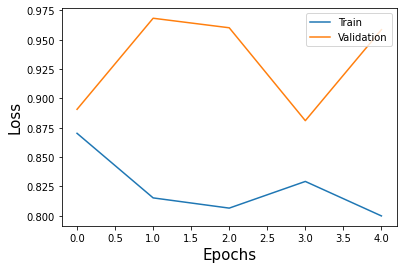

In [109]:
history = json.load(open('../checkpoint/history.json','r'))
plt.plot(range(len(history['train_loss'])), history['train_loss'])
plt.plot(range(len(history['val_loss'])), history['val_loss'])
plt.legend(['Train','Validation'], loc='upper right')
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)

In [22]:
weights = torch.load('../checkpoint/FIW_0.8150685578584671.pth')

model = ResNet18Kinship().to(device)
model.state_dict(weights['net'])
model.eval()

print('Load pretrained model')

Load pretrained model


In [87]:
train_datadir = '../data/FIW/train-faces'

family_list = os.listdir(train_datadir)
family_dropdown = ipywidgets.Dropdown(options=family_list)

member_list = os.listdir(os.path.join(train_datadir, family_dropdown.value))
member_list = [m for m in member_list if 'MID' in m]
member_dropdown = ipywidgets.Dropdown(options=member_list)

member_i_list = os.listdir(os.path.join(train_datadir, family_dropdown.value, member_dropdown.value))
member_i_dropdown = ipywidgets.Dropdown(options=member_i_list)

def family_change(change):
    member_list = os.listdir(os.path.join(train_datadir, change.new))
    member_list = [m for m in member_list if 'MID' in m]
    member_dropdown.options = member_list
    
def member_change(change):
    member_i_dropdown.options = os.listdir(os.path.join(train_datadir, family_dropdown.value, change.new))
                                     
family_dropdown.observe(family_change, names='value')
member_dropdown.observe(member_change, names='value')

In [88]:
def plot_img(family, member, member_i):
    img = Image.open(f'../data/FIW/train-faces/{family}/{member}/{member_i}')
    plt.imshow(img)

In [89]:
ipywidgets.interactive(plot_img, 
                       family=family_dropdown,
                       member=member_dropdown,
                       member_i=member_i_dropdown)

interactive(children=(Dropdown(description='family', options=('F0774', 'F0288', 'F0612', 'F0389', 'F0942', 'F0…

In [202]:
class KinshipInferDataset(torch.utils.data.Dataset):
    def __init__(self, img_path, transform):
        self.p = img_path
        self.transform = transform
        
    def __len__(self):
        return len(self.p1)
    
    def __getitem__(self, idx):
        
        # anchor image path
        anchor_path = self.p1[idx]
        
        # load images and convert RGB to grayscale
        anchor = Image.open(anchor_path).convert("L")
            
        # transform
        anchor = self.transform(anchor)
        
        return anchor

In [200]:
val_imgs_path = list(set(val_path['p1'].tolist() + val_path['p2'].tolist()))
val_imgs_path.sort()

In [ ]:
val_imgs

In [183]:
def inference(model, testloader, device):
    p1_embed_list = []
    p2_embed_list = []
    with torch.no_grad():
        for batch_idx, (anchors, positives, _) in enumerate(tqdm(testloader, desc='Inference')):
            # inputs and targets
            anchors, positives = anchors.to(device), positives.to(device)
            
            # model output
            anchors_output = model(anchors.to(device))
            positives_output = model(positives.to(device))
            
            # distance
            p1_embed_list.append(anchors_output.cpu().numpy())
            p2_embed_list.append(positives_output.cpu().numpy())
            
    p1_embed = np.vstack(p1_embed_list)
    p2_embed = np.vstack(p2_embed_list)
    return p1_embed, p2_embed

In [184]:
p1_embed, p2_embed = inference(model, valloader, device)

In [206]:
val_path.groupby('p1_fam').dist.mean().mean()

0.013598985734122309

In [207]:
val_path.groupby('p1_fam').dist.mean().std()

0.003194882279881789

In [209]:
train_info

,p1,p2,ptype,fid1,fid2,tags,set,nsamples
0,F0001/MID1,F0001/MID3,fs,F0001,F0001,0,0,6
1,F0001/MID1,F0001/MID4,fs,F0001,F0001,0,0,18
2,F0001/MID2,F0001/MID4,ms,F0001,F0001,0,0,15
3,F0001/MID2,F0001/MID3,ms,F0001,F0001,0,0,5
4,F0001/MID3,F0001/MID4,ss,F0001,F0001,0,0,3
...,...,...,...,...,...,...,...,...
6978,F1018/MID4,F1018/MID8,bb,F1018,F1018,962,0,100
6979,F1018/MID4,F1018/MID7,bb,F1018,F1018,962,0,100
6980,F1018/MID6,F1018/MID1,md,F1018,F1018,962,0,55
6981,F1018/MID7,F1018/MID8,bb,F1018,F1018,962,0,100
